MLP 이용 간단한 ANN을 만들어서 데이터석 진행 (KAN 비교용)

step1. Excel 데이터 가져오기

In [1]:
# 엑셀 데이터 로드 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os


file_path = "25.01.14_CO2RR_GSA.xlsx"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"파일을 찾을 수 없습니다: {file_path}")

xls = pd.ExcelFile("25.01.14_CO2RR_GSA.xlsx") # file_path 변수 실제 활용
X  = pd.read_excel(xls, sheet_name='Input')
df_out = pd.read_excel(xls, sheet_name='Output')

Y = df_out[['MSP ($/kgCO)']]  # MSP ($/kgCO)  # Required energy_total (MJ/kgCO)







step2. 데이터 분리 및 스케일링 _ 여기서는 평균 0 표준편차 1로 스케일링함

In [2]:
# 1차 분할 (test 분리)
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# 2차 분할(train, valid 분리)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.2, random_state=42)

# train:valid:test = 64:16:20

# 데이터 스케일링(표준화)(평균, 표준편차 이용)

# **중요** : 스케일러는 반드시 *훈련 데이터(X_train)*에만 fit 해야한다. 그래야 valid나 test 데이터의 정보가 누출될 위험을 줄인다

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)  # X_train 데이터를 이용해 scaler_X.transform을 학습 + X_train_scaled 반환
X_val_scaled = scaler_X.transform(X_val) # train 데이터로 학습한 scaler_X.transform 함수로 다른 것들도 학습
X_test_scaled = scaler_X.transform(X_test) 

scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)  # Y_train 데이터를 이용해 scaler_Y.transform을 학습 + Y_train_scaled 반환
Y_val_scaled = scaler_Y.transform(Y_val)
Y_test_scaled = scaler_Y.transform(Y_test)

# 분리한 결과 어떻게 나오는지 확인해보기

print("\n--- 데이터 분할 및 전처리 최종 결과 ---")
print(f"훈련 데이터 형태: X({X_train_scaled.shape}), Y({Y_train_scaled.shape})")
print(f"검증 데이터 형태: X({X_val_scaled.shape}), Y({Y_val_scaled.shape})")
print(f"테스트 데이터 형태: X({X_test_scaled.shape}), Y({Y_test_scaled.shape})")

print("\n\n 스케일링된 훈련 데이터(X_train_scaled) 샘플:")
print(pd.DataFrame(X_train_scaled, columns=X_train.columns).head())  
# .head()는 첫번째 5줄만 출력 , numpy 배열은 컬럼명이 없어 데이터 구조가 한눈에 파악하기 어렵다. 
# 그래서 pd.DataFrame(..., columns=...)을 이용하면, 스케일링된 데이터를 원래 컬럼명과 함께 보기 좋게 pandas DataFrame으로 변환 이용


--- 데이터 분할 및 전처리 최종 결과 ---
훈련 데이터 형태: X((1600, 8)), Y((1600, 1))
검증 데이터 형태: X((400, 8)), Y((400, 1))
테스트 데이터 형태: X((501, 8)), Y((501, 1))


 스케일링된 훈련 데이터(X_train_scaled) 샘플:
   Current density (mA/cm2)  Faradaic efficiency (%)  CO coversion  \
0                  1.441673                 0.360241      0.532953   
1                 -0.926417                -1.171090     -0.246477   
2                  0.172068                 0.046016     -1.299123   
3                 -0.875356                -0.994082      1.391436   
4                  1.623833                -1.276747      1.126541   

   Voltage (V)  Electricity cost ($/kWh)  Membrain cost ($/m2)  \
0    -0.358187                  1.459581             -0.498390   
1     0.537111                  0.955127              1.237291   
2     1.189616                  0.946880             -1.165533   
3    -0.278176                 -1.075060             -0.520536   
4     0.286041                 -0.100515             -1.697034   

   Catp

step3. MLP(ANN) 구조 설계 및 여러 신경망 층 구조에 대한 GridSearchCV 진행을 통해 최적 구조 찾기

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from scikeras.wrappers import KerasRegressor  # scikeras 권장
from sklearn.model_selection import GridSearchCV








# 1. 모델 생성 함수 / units1 = 은닉층 1층 / units2 = 은닉층2층
def create_ann_model(units1=32, units2=16, activation='relu'):
    model = Sequential([
        Input(shape=(8,)),             # 입력 특성 8개
        Dense(units1, activation=activation),
        Dense(units2, activation=activation),
        Dense(1, activation='linear')
    ])
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    return model


# 2. 래퍼 정의 (scikeras)
regressor = KerasRegressor(
    model=create_ann_model,    # 반드시 함수명만!
    verbose=0                  # fit epoch 로그 감춤
)



# 3. 모델 생성 및 구조 확인
# Required energy_total 예측 모델
#ann_model = create_ann_model()

# 모델의 구조를 요약하여 출력합니다.
#print("--- 'Required energy_total' 예측 모델 구조 ---")
#ann_model.summary()




# 3. GridSearch를 위한 파라미터 그리드 정의
param_grid = {
    'model__units1': [16, 32],      # 첫 은닉층 뉴런수 (은닉층1)
    'model__units2': [8, 16],       # 두 번째 은닉층 뉴런수 (은닉층2)
    'model__activation': ['relu', 'tanh'],
    'batch_size': [32],             # 배치 사이즈
    'epochs': [100],               # 학습 epoch 수 --- 50,100 이렇게 쓰기
}




# 4. GridSearchCV 객체 생성
grid = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    cv=3,                              # 3-fold 교차검증
    scoring='neg_mean_squared_error',  # MSE가 낮을수록 좋으니 음수로 반환
    n_jobs=-1
)

# 5. 학습 (여기서 Y_train_scaled.shape = (n_samples, 1)여야 함)
# scikit-learn의 GridSearchCV는 numpy array (2D 권장)
grid_result = grid.fit(X_train_scaled, Y_train_scaled)


# 6. 결과 출력
print("최적 하이퍼파라미터:", grid_result.best_params_)
print("최적 평균 검증 MSE:", -grid_result.best_score_)




# 7. 최적 파라미터 추출 / best_params에 다 저장이 되어있다
best_params = grid_result.best_params_
optimal_units1 = best_params['model__units1']
optimal_units2 = best_params['model__units2'] 
optimal_activation = best_params['model__activation']
optimal_batch_size = best_params['batch_size']


# GridSearchCV 결과 시각화
cv_results = pd.DataFrame(grid_result.cv_results_)
print("\n=== GridSearchCV 상세 결과 ===")
print(cv_results[['params', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False))



# 8. 최적 파라미터로 모델 생성
def create_optimal_model():
    model = Sequential([
        Input(shape=(8,)),
        Dense(optimal_units1, activation=optimal_activation),
        Dense(optimal_units2, activation=optimal_activation),
        Dense(1, activation='linear')
    ])
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    return model

ann_model = create_optimal_model()

# 9. 최적 모델 구조 보여주기
print(f"최적 모델 구조:8- {optimal_units1}-{optimal_units2}, activation: {optimal_activation}, -1")




# 7. (선택) 결과 table을 보기 좋게 정리
#import pandas as pd
#cv_results = pd.DataFrame(grid_result.cv_results_)
#display(cv_results.sort_values('mean_test_score', ascending=False))


최적 하이퍼파라미터: {'batch_size': 32, 'epochs': 100, 'model__activation': 'tanh', 'model__units1': 32, 'model__units2': 16}
최적 평균 검증 MSE: 0.10151575571815137

=== GridSearchCV 상세 결과 ===
                                              params  mean_test_score  \
7  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.101516   
6  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.109080   
4  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.141743   
2  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.154954   
3  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.169103   
1  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.172488   
5  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.172505   
0  {'batch_size': 32, 'epochs': 100, 'model__acti...        -0.187275   

   std_test_score  
7        0.022988  
6        0.017376  
4        0.025751  
2        0.030629  
3        0.036286  
1        0.031335  
5        0.047959  
0  

step4. MLP(ANN) 모델 컴파일

step4. 모델 학습 및 plot

--- 모델 학습을 시작합니다 ---
Epoch 1/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9878 - mean_absolute_error: 0.6284 - val_loss: 0.5955 - val_mean_absolute_error: 0.4301
Epoch 2/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5015 - mean_absolute_error: 0.4289 - val_loss: 0.5824 - val_mean_absolute_error: 0.4359
Epoch 3/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5682 - mean_absolute_error: 0.4419 - val_loss: 0.5814 - val_mean_absolute_error: 0.4269
Epoch 4/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6200 - mean_absolute_error: 0.4420 - val_loss: 0.5720 - val_mean_absolute_error: 0.4264
Epoch 5/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4949 - mean_absolute_error: 0.4266 - val_loss: 0.5727 - val_mean_absolute_error: 0.4399
Epoch 6/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5498 - mean_absolute_error: 0.4413 - val_loss: 0.5706 - val_mean_absolute_error: 0.4246
Epoch 7/1000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5429 - mean_absol

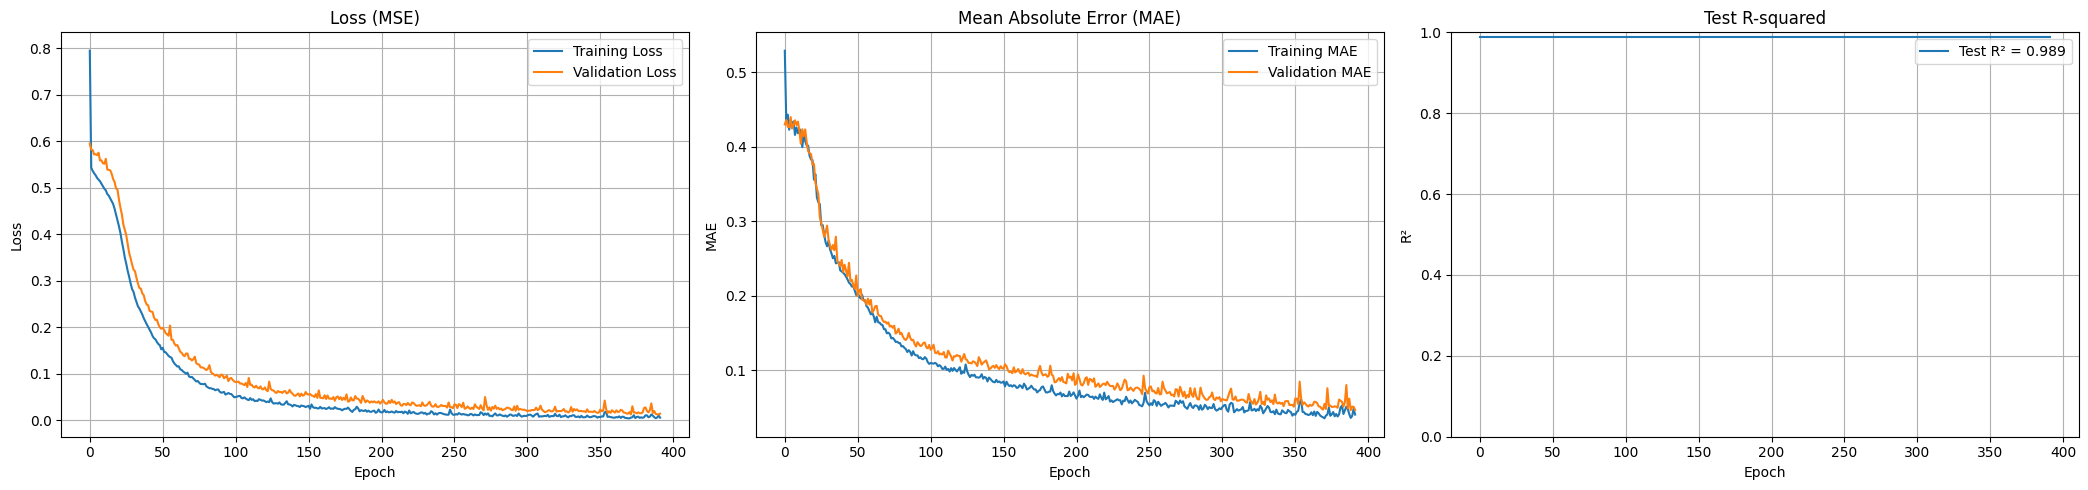

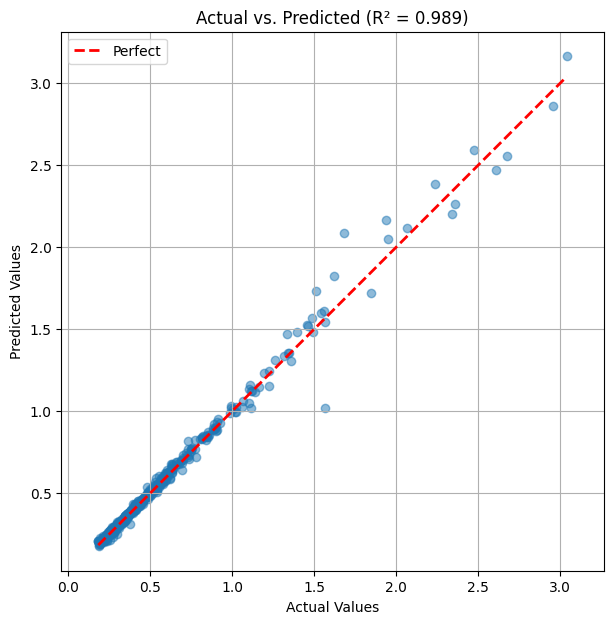

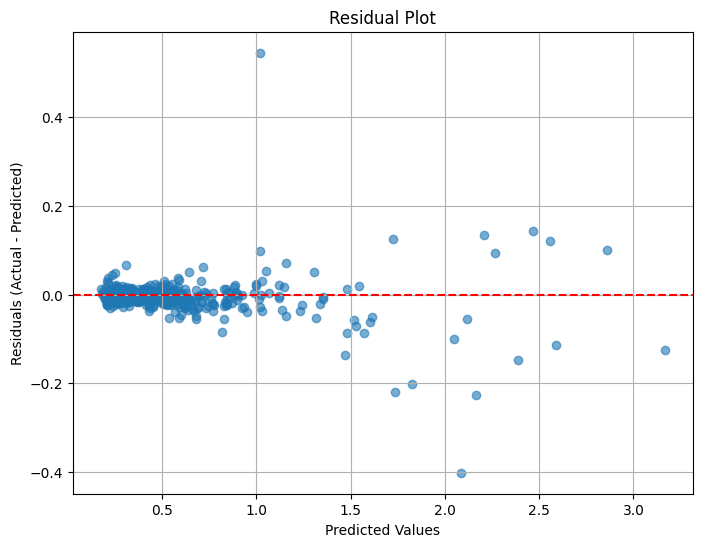


=== 최종 모델 성능 요약 ===
모델 구조: 8-32-16-1
활성화 함수: tanh
최적 epoch: 372
테스트 R²: 0.9888
테스트 MAE: 0.0444


In [4]:
# 1. 필요한 라이브러리 불러오기
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import EarlyStopping







# 2. 모델 학습 (Training)
print("--- 모델 학습을 시작합니다 ---")

early_stopping = EarlyStopping(
    monitor='val_loss',         # 검증 손실 기준
    patience=20,                # 개선되지 않는 epoch 10회 동안 기다리기(8~20 추천)
    restore_best_weights=True   # 가장 좋은 가중치로 복원
)


history = ann_model.fit(
    X_train_scaled, 
    Y_train_scaled,
    epochs=1000, #충분히 큰 값으로 설정
    batch_size=optimal_batch_size, #  # GridSearchCV 결과 활용
    validation_data=(X_val_scaled, Y_val_scaled),
    callbacks=[early_stopping],  # 콜백 추가 / overfitting 뜨기 전에 끊기
    verbose=1 # 학습 진행 로그를 상세하게 출력. (=에포크마다 손실/평가지표가 콘솔에 실시간 표시됨)
)
print("\n--- 모델 학습 완료 ---")









# 3. 모델 성능 평가 (Evaluation)
print("\n--- 테스트 데이터로 모델 성능을 평가합니다 ---")
test_loss, test_mae = ann_model.evaluate(X_test_scaled, Y_test_scaled, verbose=0)
print(f"테스트 데이터 손실 (MSE): {test_loss:.4f}")
print(f"테스트 데이터 평균 절대 오차 (MAE): {test_mae:.4f}")




# 4. 테스트 데이터 예측 및 R² 계산
Y_pred_scaled = ann_model.predict(X_test_scaled)
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
Y_test_true = Y_test.values            # DataFrame에서 numpy로 변환

r2 = r2_score(Y_test_true, Y_pred)
print(f"테스트 데이터 결정계수 (R²): {r2:.4f}")

best_epoch = np.argmin(history.history['val_loss']) + 1  # 1-base
print(f"최적의 epoch: {best_epoch}")
print(f"최소 val_loss: {history.history['val_loss'][best_epoch-1]:.5f}")



# 5. 학습 과정 시각화 (Loss, MAE, R²)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 5))

# Loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss (MSE)')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)

# MAE
ax2.plot(history.history['mean_absolute_error'], label='Training MAE')
ax2.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
ax2.set_title('Mean Absolute Error (MAE)')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('MAE'); ax2.legend(); ax2.grid(True)

# R² 수기계산(별도 그래프)
ax3.plot([r2]*len(history.history['loss']), label=f'Test R² = {r2:.3f}')
ax3.set_title('Test R-squared')
ax3.set_xlabel('Epoch'); ax3.set_ylabel('R²'); ax3.legend(); ax3.grid(True)
ax3.set_ylim(bottom=0, top=1)

plt.tight_layout()
plt.show()




# 6. 실제값-예측값 산점도
plt.figure(figsize=(7,7))
plt.scatter(Y_test_true, Y_pred, alpha=0.5)
plt.plot([Y_test_true.min(), Y_test_true.max()],
         [Y_test_true.min(), Y_test_true.max()], 'r--', lw=2, label='Perfect')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs. Predicted (R² = {r2:.3f})")
plt.legend(); plt.grid(True); plt.axis('equal')
plt.show()




# 7. 잔차 플롯 (residuals)
residuals = (Y_test_true.flatten() - Y_pred.flatten())
plt.figure(figsize=(8,6))
plt.scatter(Y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()


# 모델 성능 요약 
print(f"\n=== 최종 모델 성능 요약 ===")
print(f"모델 구조: 8-{optimal_units1}-{optimal_units2}-1")
print(f"활성화 함수: {optimal_activation}")
print(f"최적 epoch: {best_epoch}")
print(f"테스트 R²: {r2:.4f}")
print(f"테스트 MAE: {test_mae:.4f}")



밑에는 과거 코드들